## Data Cleaning and Shape Examining 


## Home Depot Product Search Relevance



Shoppers rely on Home Depot’s product authority to find and buy the latest products and to get timely solutions to their home improvement needs. From installing a new ceiling fan to remodeling an entire kitchen, with the click of a mouse or tap of the screen, customers expect the correct results to their queries – quickly. Speed, accuracy and delivering a frictionless customer experience are essential.

In this competition, Home Depot is asking Kagglers to help them improve their customers' shopping experience by developing a model that can accurately predict the relevance of search results.

Search relevancy is an implicit measure Home Depot uses to gauge how quickly they can get customers to the right products. Currently, human raters evaluate the impact of potential changes to their search algorithms, which is a slow and subjective process. By removing or minimizing human input in search relevance evaluation, Home Depot hopes to increase the number of iterations their team can perform on the current search algorithms.

### Data description

This data set contains a number of products and real customer search terms from Home Depot's website. The challenge is to predict a relevance score for the provided combinations of search terms and products. To create the ground truth labels, Home Depot has crowdsourced the search/product pairs to multiple human raters.

The relevance is a number between 1 (not relevant) to 3 (highly relevant). For example, a search for "AA battery" would be considered highly relevant to a pack of size AA batteries (relevance = 3), mildly relevant to a cordless drill battery (relevance = 2), and not relevant to a snow shovel (relevance = 1).

Each pair was evaluated by at least three human raters. The provided relevance scores are the average value of the ratings. There are three additional things to know about the ratings:

The specific instructions given to the raters is provided in relevance_instructions.docx.
Raters did not have access to the attributes.
Raters had access to product images, while the competition does not include images.
Your task is to predict the relevance for each pair listed in the test set. Note that the test set contains both seen and unseen search terms.



### File descriptions

- train.csv - the training set, contains products, searches, and relevance scores
- test.csv - the test set, contains products and searches. You must predict the relevance for these pairs.
- product_descriptions.csv - contains a text description of each product. You may join this table to the training or test set via the product_uid.
- attributes.csv -  provides extended information about a subset of the products (typically representing detailed technical specifications). Not every product will have attributes.


### Data fields

- id - a unique Id field which represents a (search_term, product_uid) pair
- product_uid - an id for the products
- product_title - the product title
- product_description - the text description of the product (may contain HTML content)
- search_term - the search query
- relevance - the average of the relevance ratings for a given id
- name - an attribute name
- value - the attribute's value

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

training_data = pd.read_csv("input/train.csv.zip", encoding="ISO-8859-1")
testing_data = pd.read_csv("input/test.csv.zip", encoding="ISO-8859-1")
attribute_data = pd.read_csv('input/attributes.csv.zip')
descriptions = pd.read_csv('input/product_descriptions.csv.zip')


# training_data = pd.read_csv("../input/train.csv", encoding="ISO-8859-1")
# testing_data = pd.read_csv("../input/test.csv", encoding="ISO-8859-1")
# attribute_data = pd.read_csv('../input/attributes.csv')
# descriptions = pd.read_csv('../input/product_descriptions.csv')


Let's try to examing the data and try to spot if there are anything suspicious about it

In [3]:
print("training data shape is:",training_data.shape)
print("testing data shape is:",testing_data.shape)
print("attribute data shape is:",attribute_data.shape)
print("description data shape is:",descriptions.shape)

training data shape is: (74067, 5)
testing data shape is: (166693, 4)
attribute data shape is: (2044803, 3)
description data shape is: (124428, 2)


In [4]:
print("training data has empty values:",training_data.isnull().values.any())
print("testing data has empty values:",testing_data.isnull().values.any())
print("attribute data has empty values:",attribute_data.isnull().values.any())
print("description data has empty values:",descriptions.isnull().values.any())

training data has empty values: False
testing data has empty values: False
attribute data has empty values: True
description data has empty values: False


In [5]:
training_data.head(10)

id  product_uid                                      product_title  \
0   2       100001                  Simpson Strong-Tie 12-Gauge Angle   
1   3       100001                  Simpson Strong-Tie 12-Gauge Angle   
2   9       100002  BEHR Premium Textured DeckOver 1-gal. #SC-141 ...   
3  16       100005  Delta Vero 1-Handle Shower Only Faucet Trim Ki...   
4  17       100005  Delta Vero 1-Handle Shower Only Faucet Trim Ki...   
5  18       100006  Whirlpool 1.9 cu. ft. Over the Range Convectio...   
6  20       100006  Whirlpool 1.9 cu. ft. Over the Range Convectio...   
7  21       100006  Whirlpool 1.9 cu. ft. Over the Range Convectio...   
8  23       100007  Lithonia Lighting Quantum 2-Light Black LED Em...   
9  27       100009  House of Fara 3/4 in. x 3 in. x 8 ft. MDF Flut...   

            search_term  relevance  
0         angle bracket       3.00  
1             l bracket       2.50  
2             deck over       3.00  
3      rain shower head       2.33  
4    shower only faucet       2.67  
5        convection otr       3.00  
6  microwave over stove       2.67  
7            microwaves       3.00  
8       emergency light       2.67  
9               mdf 3/4       3.00

In [6]:
print("there are in total {} products ".format(len(training_data.product_title.unique())))
print("there are in total {} search query ".format(len(training_data.search_term.unique())))
print("there are in total {} product_uid".format(len(training_data.product_uid.unique())))




there are in total 53489 products 
there are in total 11795 search query 
there are in total 54667 product_uid


In [7]:
testing_data.head(10)

id  product_uid                                      product_title  \
0   1       100001                  Simpson Strong-Tie 12-Gauge Angle   
1   4       100001                  Simpson Strong-Tie 12-Gauge Angle   
2   5       100001                  Simpson Strong-Tie 12-Gauge Angle   
3   6       100001                  Simpson Strong-Tie 12-Gauge Angle   
4   7       100001                  Simpson Strong-Tie 12-Gauge Angle   
5   8       100001                  Simpson Strong-Tie 12-Gauge Angle   
6  10       100003  STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...   
7  11       100003  STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...   
8  12       100003  STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...   
9  13       100004  Grape Solar 265-Watt Polycrystalline Solar Pan...   

                 search_term  
0          90 degree bracket  
1           metal l brackets  
2           simpson sku able  
3       simpson strong  ties  
4  simpson strong tie hcc668  
5            wood connectors  
6        bath and shower kit  
7             bath drain kit  
8       one piece tub shower  
9                solar panel

In [8]:
print("there are in total {} products ".format(len(testing_data.product_title.unique())))
print("there are in total {} search query ".format(len(testing_data.search_term.unique())))
print("there are in total {} product_uid".format(len(testing_data.product_uid.unique())))





there are in total 94731 products 
there are in total 22427 search query 
there are in total 97460 product_uid


In [9]:
attribute_data.head(10)

product_uid            name  \
0     100001.0        Bullet01   
1     100001.0        Bullet02   
2     100001.0        Bullet03   
3     100001.0        Bullet04   
4     100001.0        Bullet05   
5     100001.0        Bullet06   
6     100001.0        Bullet07   
7     100001.0           Gauge   
8     100001.0        Material   
9     100001.0  MFG Brand Name   

                                               value  
0  Versatile connector for various 90° connection...  
1  Stronger than angled nailing or screw fastenin...  
2  Help ensure joints are consistently straight a...  
3              Dimensions: 3 in. x 3 in. x 1-1/2 in.  
4                           Made from 12-Gauge steel  
5          Galvanized for extra corrosion resistance  
6  Install with 10d common nails or #9 x 1-1/2 in...  
7                                                 12  
8                                   Galvanized Steel  
9                                 Simpson Strong-Tie

In [10]:
print("there are in total {} product_uid ".format(len(attribute_data.product_uid.unique())))
print("there are in total {} names ".format(len(attribute_data.name.unique())))
print("there are in total {} values".format(len(attribute_data.value.unique())))






there are in total 86264 product_uid 
there are in total 5411 names 
there are in total 307588 values


In [11]:
descriptions.head(10)

product_uid                                product_description
0       100001  Not only do angles make joints stronger, they ...
1       100002  BEHR Premium Textured DECKOVER is an innovativ...
2       100003  Classic architecture meets contemporary design...
3       100004  The Grape Solar 265-Watt Polycrystalline PV So...
4       100005  Update your bathroom with the Delta Vero Singl...
5       100006  Achieving delicious results is almost effortle...
6       100007  The Quantum Adjustable 2-Light LED Black Emerg...
7       100008  The Teks #10 x 1-1/2 in. Zinc-Plated Steel Was...
8       100009  Get the House of Fara 3/4 in. x 3 in. x 8 ft. ...
9       100010  Valley View Industries Metal Stakes (4-Pack) a...

In [12]:
print("there are in total {} product_uid ".format(len(descriptions.product_uid.unique())))
print("there are in total {} product_descriptions ".format(len(descriptions.product_description.unique())))







there are in total 124428 product_uid 
there are in total 110128 product_descriptions 


In [13]:
(descriptions.product_description.str.count('\d+') + 1).hist(bins=30)
(descriptions.product_description.str.count('\W')+1).hist(bins=30)




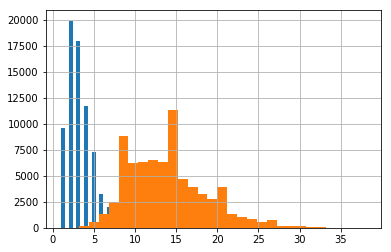

In [14]:
(training_data.product_title.str.count("\\d+") + 1).hist(bins=30)#plot number of digits in title
(training_data.product_title.str.count("\\w+") + 1).hist(bins=30)#plot number of digits in title





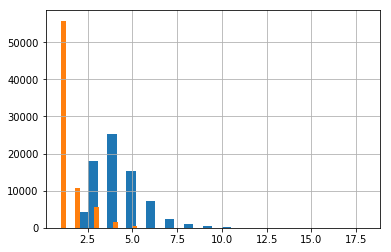

In [15]:
(training_data.search_term.str.count("\\w+") + 1).hist(bins=30) #plot number of words in search therms
(training_data.search_term.str.count("\\d+") + 1).hist(bins=30) #plot number of digits in search terms







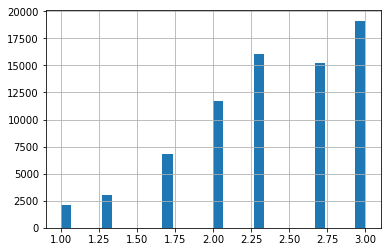

In [16]:
(training_data.relevance ).hist(bins=30)

/Users/iurii/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


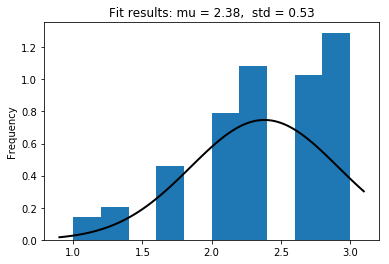

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

training_data.relevance.plot(kind='hist', normed=True)

mu, std = norm.fit(training_data.relevance)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [18]:
print('total data has html tags in',descriptions.product_description.str.count('<br$').values.sum())

total data has html tags in 173


In [19]:
descriptions[descriptions.product_description.str.contains("<br")].values.tolist()[:3]

[[100050,
  'Sit back and relax in comfort and style in these Beverly Patio Dining Armchairs with Bare Cushions (2-Pack) from Hampton Bay. Perfect for a deck, porch, patio or sunroom, the chairs are made with a powder-coated, sturdy and durable rust-resistant, steel-reinforced frame with all-weather resin wicker to help withstand outdoor elements. Inspired by vintage styles, they feature a woven multi-brown wicker finish and include bare seat cushions that can be customized with slipcovers through the Choose Your Own Color option.Part of the Choose Your Own Color program, slipcovers for cushions must be purchased separatelyAll-weather resin wicker crafts a versatile piece for indoor and outdoor useFashioned with a multi-brown wicker finish for a vintage aesthetic in your outdoor living areaNo assembly requiredAll components packed in 1 boxCoordinates with other brown wicker items in the Beverly collection (sold separately)2-year limited frame, fabric and weave warrantyPowder-coated ste

In [20]:
descriptions.product_description.str.contains("Click here to review our return policy for additional information regarding returns").values.sum()

173

In [21]:
training_data[training_data.search_term.str.contains("^\\d+ . \\d+$")].head(10)

id  product_uid                                      product_title  \
3377   10452       101800  Kaleen Habitat Bahama Rose Paprika 4 ft. x 6 f...   
3650   11307       101959  Pressure-Treated Timber #2 Southern Yellow Pin...   
3766   11705       102041  Kaleen Habitat Calypso Azure 4 ft. x 6 ft. Ind...   
4513   14166       102472  Safavieh Lyndhurst Sage/Ivory 4 ft. x 6 ft. Ar...   
7247   22691       104370  Wilsonart 48 in. x 96 in. Laminate Sheet in Mo...   
7485   23405       104575  Yosemite Home Decor Undermount Stainless Steel...   
13639  42190       110172                   Sigman 20 ft. x 20 ft. Blue Tarp   
15523  47882       112008  Wilsonart 48 in. x 96 in. Laminate Sheet in Su...   
21335  65959       118174        1 in. Depth EZ Flow Heavy Duty (Case of 12)   
23618  72613       120571  Honeywell 1 in. Allergen Superior Pleated FPR ...   

      search_term  relevance  
3377        4 x 6       2.00  
3650        4 x 6       1.67  
3766        4 x 6       3.00  
4513        4 x 6       1.33  
7247      48 x 96       2.33  
7485      23 x 38       2.33  
13639     20 x 20       2.67  
15523     48 x 96       3.00  
21335     20 x 20       1.67  
23618     20 x 20       1.67

In [22]:
training_data[training_data.product_uid==100030]

id  product_uid                                   product_title  \
44  164       100030  9.1 in. x 5.8 in. White Designer Shelf Bracket   
45  165       100030  9.1 in. x 5.8 in. White Designer Shelf Bracket   
46  166       100030  9.1 in. x 5.8 in. White Designer Shelf Bracket   

       search_term  relevance  
44  8 4616809045 9       1.67  
45   shelf bracket       3.00  
46  white 4shelves       1.67

from above the following conclusion follows. 
   - At first there exists fields which has html tags in for __description__ dataset. (maybe and error made by the scrapper) along with _Click here to review our return policy_
   - There is no missing/empty values in any of these datasets 
   - in dataset __description__ field product_description contains more digits than word characters
   - some query in dataset __training__ are too straight, it's hard to guess exactly what user meant in terms of broad  sense
   - some of the search query in dataset __training__ has too specific meaning like 8 4616809045 9	
   - number of diggits appearence in the product title tends to be greater number of characters for dataset __training__ (and the same is true for search query field)
   - the relevancy score is between 1 and 3. Because the density of product whose relevancy score is between 2 and 3 is higher we can conclude that most of search query has been classifield between 2 and 3
   - The histogram of relevancy score doesn't follow standard distribution pattern
   
   
   
In order to continue the analysis we will need the whole datasets
   - description datasets might be joined together to training by the product_uid (the same holds for attribute datasets) then clean the html parts
   
   

## Data cleaning

In [23]:
## let's create first the cleaning functions
from bs4 import BeautifulSoup
import lxml
import re
import nltk
from nltk.corpus import stopwords # Import the stop word list
from nltk.metrics import edit_distance
from string import punctuation
from collections import Counter


def remove_html_tag(text):
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text().replace('Click here to review our return policy for additional information regarding returns', '')
    return text

def str_stemmer(doc):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)

def str_stemmer_title(s):
#     return " ".join([stemmer.stem(word) for word in s.lower().split()])
    return " ".join(map(stemmer.stem, s.lower().split()))

def str_common_word(str1, str2):
    whole_set = set(str1.split())
#     return sum(int(str2.find(word)>=0) for word in whole_set)
    return sum(int(str2.find(word)>=0) for word in whole_set)


def get_shared_words(row_data):
    return np.sum([str_common_word(*row_data[:-1]), str_common_word(*row_data[1:])])



In [24]:
############### cleaning html tags ##################
has_tag_in = descriptions.product_description.str.contains('<br')
descriptions.loc[has_tag_in, 'product_description'] = descriptions.loc[has_tag_in, 'product_description'].map(lambda x:remove_html_tag(x))
###############

Examing the search query in the datasets __training__, there some misspelings for field _search_term_ contains a lot of misspelling (more than 3000). This might be fixed by using Google API 

In [25]:
import requests
import re
import time
from random import randint

START_SPELL_CHECK="<span class=\"spell\">Showing results for</span>"
END_SPELL_CHECK="<br><span class=\"spell_orig\">Search instead for"
HTML_Codes = (("'", '&#39;'),('"', '&quot;'),('>', '&gt;'),('<', '&lt;'),('&', '&amp;'))

def spell_check(s):
    q = '+'.join(s.split())
    time.sleep(  randint(0,1) ) #relax and don't let google be angry
    r = requests.get("https://www.google.co.uk/search?q="+q)
    content = r.text
    start=content.find(START_SPELL_CHECK) 
    if ( start > -1 ):
        start = start + len(START_SPELL_CHECK)
        end=content.find(END_SPELL_CHECK)
        search= content[start:end]
        search = re.sub(r'<[^>]+>', '', search)
        for code in HTML_Codes:
            search = search.replace(code[1], code[0])
        search = search[1:]
    else:
        search = s
    return search 

Indeed correcting the misspelings words might help, due to ability of reproducing the result at Kaggle, we won't do spell correction

In [26]:
training_data = pd.merge(training_data, descriptions, 
                         on="product_uid", how="left")

In [27]:
print("It has blank/empty fields ",training_data.isnull().values.sum())


It has blank/empty fields  0


## Feature Engineering

### Plan
We are going to do the following:
0. Join dataset __training__ with __description__  by  _product uid_ (already done)

2. Create num columns based on text columns
    - count number of words from search query which appears both in product_title and product_description
    - compute edit distnace from search query which appears both in product_title and product_title
    - compute the cosine similarity between search query, product_title and product_description
    - count number of words in the product description
    - create new columns for each pair
    
3. Remove all text columns

As a result we will have vectors of numbers that suites well for the machine learning.

In [28]:
print("has blank/empty values",training_data.isnull().values.any())

has blank/empty values False


In [29]:
from nltk.corpus import brown, stopwords
from nltk.cluster.util import cosine_distance
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter


def sentence_similarity(columns,stopwords=None):
    sent1, sent2 = columns[0], columns[1]
    sent1 = sent1.split(' ')
    sent2 = sent2.split(' ')
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)

def get_jaccard_sim(columns): 
    str1, str2 = columns[0], columns[1]
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


def calc_edit_dist(row):
    return edit_distance(*row)

    

In [30]:
################begin testing
## let's create first the cleaning functions
from bs4 import BeautifulSoup
import lxml
import re
import nltk
from nltk.corpus import stopwords # Import the stop word list
from nltk.metrics import edit_distance
from string import punctuation
from collections import Counter


def remove_html_tag(text):
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text().replace('Click here to review our return policy for additional information regarding returns', '')
    return text

def str_stemmer(doc):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)


def str_stemmer_tokens(tokens):
    # split into tokens by white space
#     tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)

def str_stemmer_title(s):
    return " ".join(map(stemmer.stem, s))

def str_common_word(str1, str2):
    whole_set = set(str1.split())
#     return sum(int(str2.find(word)>=0) for word in whole_set)
    return sum(int(str2.find(word)>=0) for word in whole_set)


# def str_common_word(str1, str2):
#     return sum(int(str2.find(word)>=0) for word in str1.split())


def str_common_word2(str1, str2):
    part_of_first = set(str1)
    return sum(1 for word in str2 if word in part_of_first)
#     return sum(int(str2.find(word)>=0) for word in str1.split())

def get_shared_words_mut(row_data):
    return np.sum([str_common_word2(*row_data[:-1]), str_common_word2(*row_data[1:])])


def get_shared_words_imut(row_data):
    return np.sum([str_common_word(*row_data[:-1]), str_common_word2(*row_data[1:])])
    
from nltk.corpus import brown, stopwords
from nltk.cluster.util import cosine_distance
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter


def sentence_similarity(columns,stopwords=None):
    sent1, sent2 = columns[0], columns[1]
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)

def get_jaccard_sim(columns): 
    str1, str2 = columns[0], columns[1]
    a = set(str1) 
    b = set(str2)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


In [31]:
############## apply stemming #####################
#  also .apply(, raw=True) might be a good options
# https://github.com/s-heisler/pycon2017-optimizing-pandas to see why it is done on this way
############## apply stemming #####################



training_data['search_term_tokens'] = training_data.search_term.str.lower().str.split()
training_data['product_title_tokens'] = training_data.product_title.str.lower().str.split()
training_data['product_description_tokens'] = training_data.product_description.str.lower().str.split()

training_data['search_term'] = [str_stemmer_title(_) for _ in training_data.search_term_tokens.values.tolist()]
training_data['product_title'] = [str_stemmer_tokens(_) for _ in training_data.product_title_tokens.values.tolist()]
training_data['product_description'] = [str_stemmer_tokens(_) for _ in training_data.product_description_tokens.values.tolist()]


training_data['shared_words_mut'] = [get_shared_words_mut(columns)
                         for columns in 
                         training_data[['search_term_tokens', 'product_title_tokens', 'product_description_tokens']].values.tolist()
                        ]

training_data['shared_words'] = list(map(get_shared_words_imut, training_data[['search_term','product_description', 'product_title']].values))


training_data['j_dis_sqt'] = [get_jaccard_sim(rows) for rows in training_data[["search_term_tokens","product_title_tokens"]].values]
training_data['j_dis_sqd'] = [get_jaccard_sim(rows) for rows in training_data[["search_term_tokens","product_description_tokens"]].values]

training_data['search_query_length'] = training_data.search_term.str.len()
training_data['number_of_words_in_descr'] = training_data.product_description.str.count("\\w+")


training_data['cos_dis_sqt'] = [ sentence_similarity(rows) for rows in training_data[["search_term","product_title"]].values]
training_data['cos_dis_sqd'] = [sentence_similarity(rows) for rows in training_data[["search_term","product_description"]].values]




In [32]:
# this two lines takeing too long time to execute
# training_data["edistance_sprot"] = [edit_distance(word1, word2) for word1, word2 in
#                                     training_data[["search_term","product_title"]].values.tolist()]


# training_data["edistance_sd"] = [edit_distance(word1, word2) for word1, word2 in
#                                     training_data[["search_term","product_description"]].values.tolist()]

In [32]:
# training_data.corr()
training_data.head(3)

id  product_uid     ...     cos_dis_sqt cos_dis_sqd
0   2       100001     ...        0.584761    0.667018
1   3       100001     ...        0.437595    0.635434
2   9       100002     ...        0.783244    0.700815

[3 rows x 17 columns]

__test dataset__
we have to have to apply symmetric transformation for both data set, except relevance score field since it is target field. Except we are not allow to take any actions which might lead to overfitting the data

In [33]:
testing_data = pd.merge(testing_data, descriptions, 
                         on="product_uid", how="left")
print("has blank/empty values",testing_data.isnull().values.any())

has blank/empty values False


In [34]:
############## apply stemming for test data #####################
# testing_data['search_term'] = list(map(str_stemmer_title, testing_data['search_term'].values))
# testing_data['product_title'] = list(map(str_stemmer, testing_data['product_title'].values))
# testing_data['product_description'] = list(map(str_stemmer, testing_data['product_description'].values))
testing_data['search_term_tokens'] = testing_data.search_term.str.lower().str.split()
testing_data['product_title_tokens'] = testing_data.product_title.str.lower().str.split()
testing_data['product_description_tokens'] = testing_data.product_description.str.lower().str.split()

testing_data['search_term'] = [str_stemmer_title(_) for _ in testing_data.search_term_tokens.values.tolist()]
testing_data['product_title'] = [str_stemmer_tokens(_) for _ in testing_data.product_title_tokens.values.tolist()]
testing_data['product_description'] = [str_stemmer_tokens(_) for _ in testing_data.product_description_tokens.values.tolist()]

############## end stemming #####################

In [35]:
############## building custome feature for test data, let's build a few of them before compare which one is the best ###########
# testing_data['shared_words'] = list(map(get_shared_words, testing_data[['search_term','product_description', 'product_title']].values))
# testing_data["edistance_sprot"] = list(map(calc_edit_dist, testing_data[["search_term","product_title"]].values))
# testing_data["edistance_sd"] = list(map(calc_edit_dist, testing_data[["search_term","product_description"]].values))


# testing_data['cos_dis_sqt'] = list(map(sentence_similarity ,testing_data[["search_term","product_title"]].values))
# testing_data['cos_dis_sqd'] = list(map(sentence_similarity, testing_data[["search_term","product_description"]].values))



# testing_data['j_dis_sqt'] = list(map(get_jaccard_sim, testing_data[["search_term","product_title"]].values))
# testing_data['j_dis_sqd'] = list(map(get_jaccard_sim, testing_data[["search_term","product_description"]].values))

# testing_data['j_dis_sqt'] = list(map(get_jaccard_sim, testing_data[["search_term","product_title"]].values))
# testing_data['j_dis_sqd'] = list(map(get_jaccard_sim, testing_data[["search_term","product_description"]].values))

# testing_data['search_query_length'] = testing_data.search_term.str.len()
# testing_data['number_of_words_in_descr'] = testing_data.product_description.str.count("\\w+")

testing_data['shared_words_mut'] = [get_shared_words_mut(columns)
                         for columns in 
                         testing_data[['search_term_tokens', 'product_title_tokens', 'product_description_tokens']].values.tolist()
                        ]

testing_data['shared_words'] = list(map(get_shared_words_imut, testing_data[['search_term','product_description', 'product_title']].values))


testing_data['j_dis_sqt'] = [get_jaccard_sim(rows) for rows in testing_data[["search_term_tokens","product_title_tokens"]].values]
testing_data['j_dis_sqd'] = [get_jaccard_sim(rows) for rows in testing_data[["search_term_tokens","product_description_tokens"]].values]

testing_data['search_query_length'] = testing_data.search_term.str.len()
testing_data['number_of_words_in_descr'] = testing_data.product_description.str.count("\\w+")


testing_data['cos_dis_sqt'] = [ sentence_similarity(rows) for rows in testing_data[["search_term","product_title"]].values]
testing_data['cos_dis_sqd'] = [sentence_similarity(rows) for rows in testing_data[["search_term","product_description"]].values]




In [36]:
#this two lines taking too long to execute

# testing_data["edistance_sprot"] = [edit_distance(word1, word2) for word1, word2 in
#                                     testing_data[["search_term","product_title"]].values.tolist()]


# testing_data["edistance_sd"] = [edit_distance(word1, word2) for word1, word2 in
#                                     testing_data[["search_term","product_description"]].values.tolist()]


In [37]:
testing_data.corr()

id     ...       cos_dis_sqd
id                        1.000000     ...          0.028857
product_uid               0.984240     ...          0.020203
shared_words_mut         -0.050582     ...          0.142095
shared_words              0.034211     ...          0.162426
j_dis_sqt                 0.122488     ...          0.260100
j_dis_sqd                 0.073183     ...          0.311699
search_query_length       0.064054     ...          0.628685
number_of_words_in_descr -0.090713     ...          0.068046
cos_dis_sqt               0.078321     ...          0.813355
cos_dis_sqd               0.028857     ...          1.000000

[10 rows x 10 columns]

In [38]:
training_data.describe()

id    product_uid      ...        cos_dis_sqt   cos_dis_sqd
count   74067.000000   74067.000000      ...       74067.000000  74067.000000
mean   112385.709223  142331.911553      ...           0.750231      0.725384
std     64016.573650   30770.774864      ...           0.135662      0.128294
min         2.000000  100001.000000      ...           0.000000      0.000000
25%     57163.500000  115128.500000      ...           0.687111      0.666166
50%    113228.000000  137334.000000      ...           0.779008      0.751104
75%    168275.500000  166883.500000      ...           0.845656      0.815402
max    221473.000000  206650.000000      ...           1.000000      0.971390

[8 rows x 11 columns]

In [39]:
testing_data.describe()

id    product_uid      ...          cos_dis_sqt    cos_dis_sqd
count  166693.000000  166693.000000      ...        166693.000000  166693.000000
mean   123932.839741  149713.170445      ...             0.740166       0.712677
std     71518.389174   37270.476881      ...             0.138944       0.132597
min         1.000000  100001.000000      ...             0.000000       0.000000
25%     61669.000000  116665.000000      ...             0.672976       0.649393
50%    124004.000000  142445.000000      ...             0.769058       0.738709
75%    187036.000000  179444.000000      ...             0.838512       0.806693
max    240760.000000  224428.000000      ...             1.000000       0.974223

[8 rows x 10 columns]

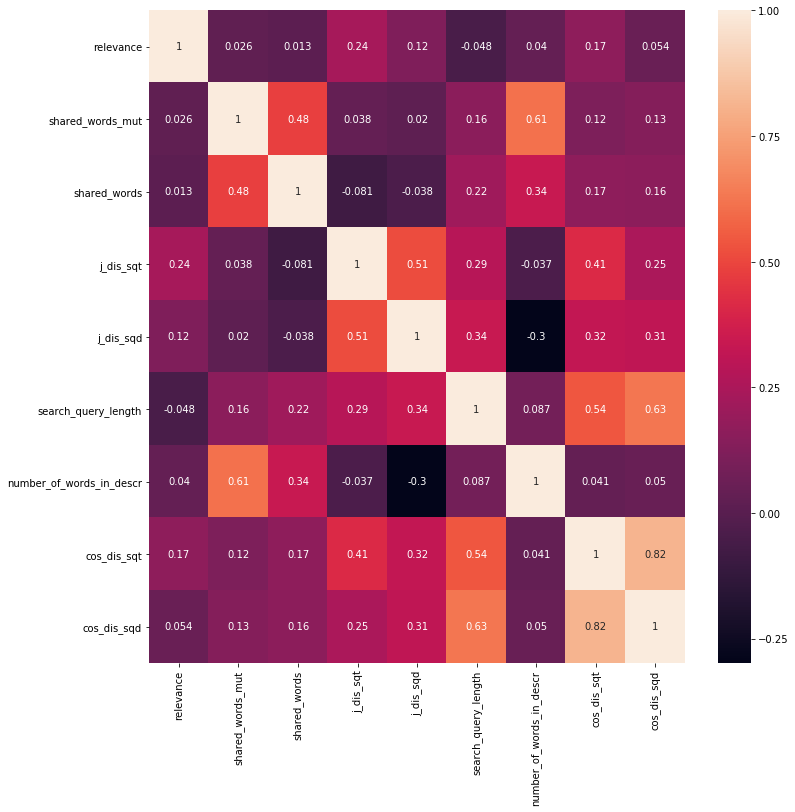

In [40]:
import seaborn as sns
plt.figure(figsize=(12, 12))
temp = training_data.drop(['product_uid','id'],axis=1)
sns.heatmap(temp.corr(), annot=True)
plt.show()

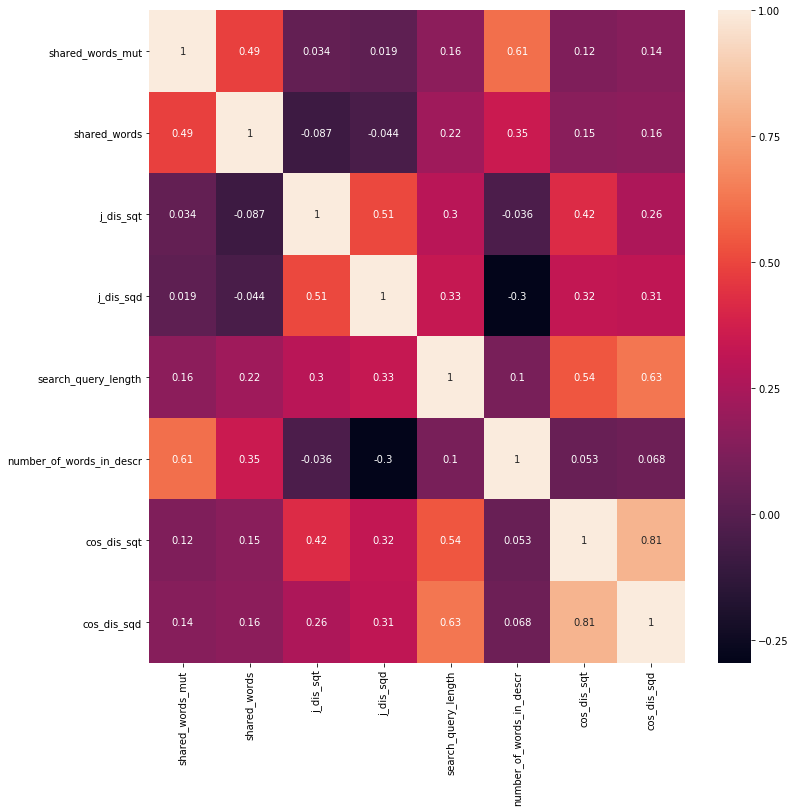

In [41]:
import seaborn as sns
plt.figure(figsize=(12, 12))
temp = testing_data.drop(['product_uid','id'],axis=1)
sns.heatmap(temp.corr(), annot=True)
plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


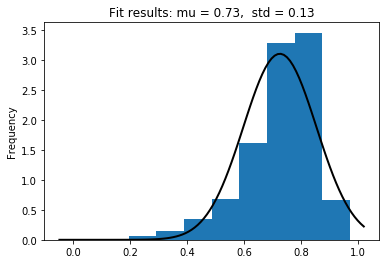

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

training_data.cos_dis_sqd.plot(kind='hist', normed=True)

mu, std = norm.fit(training_data.cos_dis_sqd)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

let's check wheather this is follows Gaussian distribution or not. Indeed it doesn't follow Gaussian distribution, that follows from Shapiro test

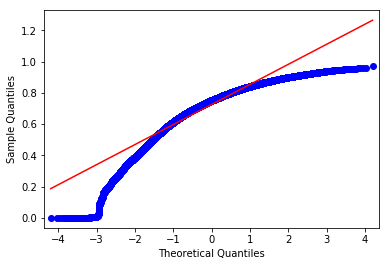

Statistics=0.909, p=0.000


/opt/conda/lib/python3.6/site-packages/scipy/stats/morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [43]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro


from matplotlib import pyplot
qqplot(training_data.cos_dis_sqd, line='s')
pyplot.show()

stat, p = shapiro(training_data.cos_dis_sqd)
print('Statistics=%.3f, p=%.3f' % (stat, p))

let's try to find out if wheather it follows normal distribution or not, by doing a few others test

In [44]:
from scipy.stats import normaltest

stat, p = normaltest(training_data.cos_dis_sqd)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=19253.808, p=0.000
Sample does not look Gaussian (reject H0)


In [45]:
from scipy.stats import anderson

result = anderson(training_data.cos_dis_sqd)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 1513.473
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


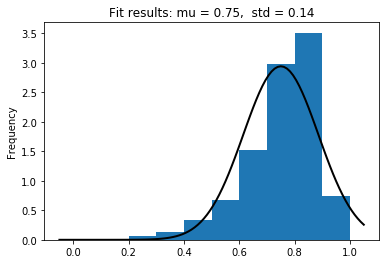

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

training_data.cos_dis_sqt.plot(kind='hist', normed=True)

mu, std = norm.fit(training_data.cos_dis_sqt)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

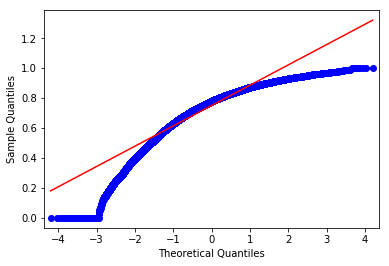

Statistics=0.903, p=0.000


/opt/conda/lib/python3.6/site-packages/scipy/stats/morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [47]:
from matplotlib import pyplot
qqplot(training_data.cos_dis_sqt, line='s')
pyplot.show()

stat, p = shapiro(training_data.cos_dis_sqt)
print('Statistics=%.3f, p=%.3f' % (stat, p))

From the below histogram we can conclude that the sum of shared words between search_query product_title, and product description follows the standard distribution.


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


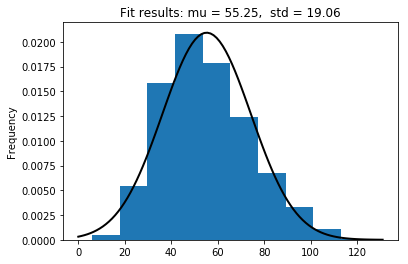

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

training_data.shared_words.plot(kind='hist', normed=True)

mu, std = norm.fit(training_data.shared_words)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

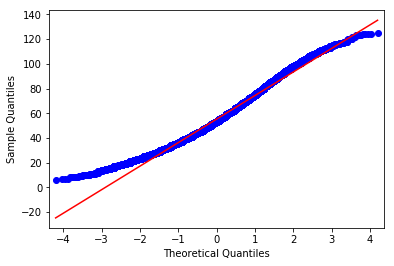

Statistics=0.983, p=0.000


/opt/conda/lib/python3.6/site-packages/scipy/stats/morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [49]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro


from matplotlib import pyplot
qqplot(training_data.shared_words, line='s')
pyplot.show()

stat, p = shapiro(training_data.shared_words)
print('Statistics=%.3f, p=%.3f' % (stat, p))

In [51]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# from scipy.stats import norm  

# training_data.edistance_sprot.plot(kind='hist', normed=True)

# mu, std = norm.fit(training_data.edistance_sprot)

# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# p = norm.pdf(x, mu, std)
# plt.plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)

# plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


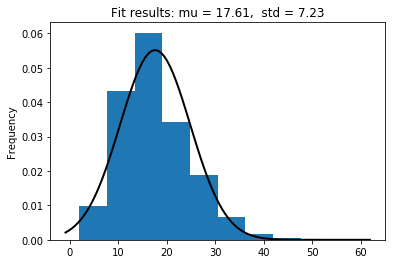

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

training_data.search_query_length.plot(kind='hist', normed=True)

mu, std = norm.fit(training_data.search_query_length)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

let's examing if the same behaviour can be spotted on __testing__ dataset

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


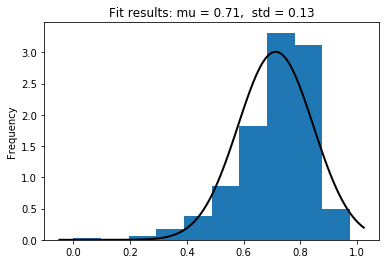

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

testing_data.cos_dis_sqd.plot(kind='hist', normed=True)

mu, std = norm.fit(testing_data.cos_dis_sqd)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


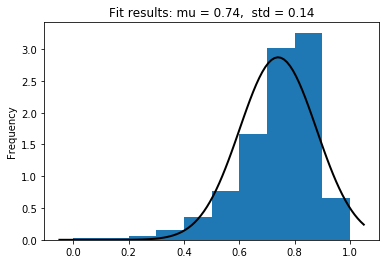

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

testing_data.cos_dis_sqt.plot(kind='hist', normed=True)

mu, std = norm.fit(testing_data.cos_dis_sqt)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


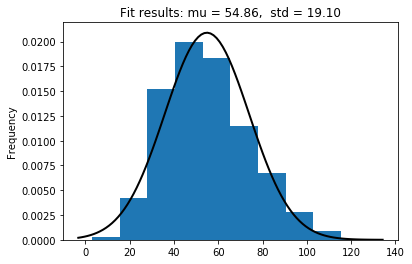

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

testing_data.shared_words.plot(kind='hist', normed=True)

mu, std = norm.fit(testing_data.shared_words)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [56]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# from scipy.stats import norm  

# testing_data.edistance_sprot.plot(kind='hist', normed=True)

# mu, std = norm.fit(testing_data.edistance_sprot)

# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# p = norm.pdf(x, mu, std)
# plt.plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)

# plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


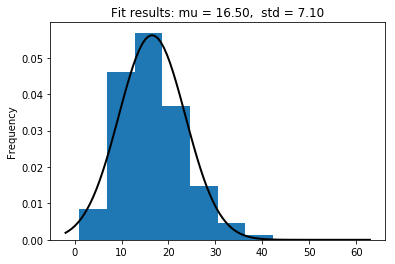

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  

testing_data.search_query_length.plot(kind='hist', normed=True)

mu, std = norm.fit(testing_data.search_query_length)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [58]:
training_data.shape

np.max([np.log(74067) / np.log(x) for x in training_data.search_query_length])


16.176543283205014

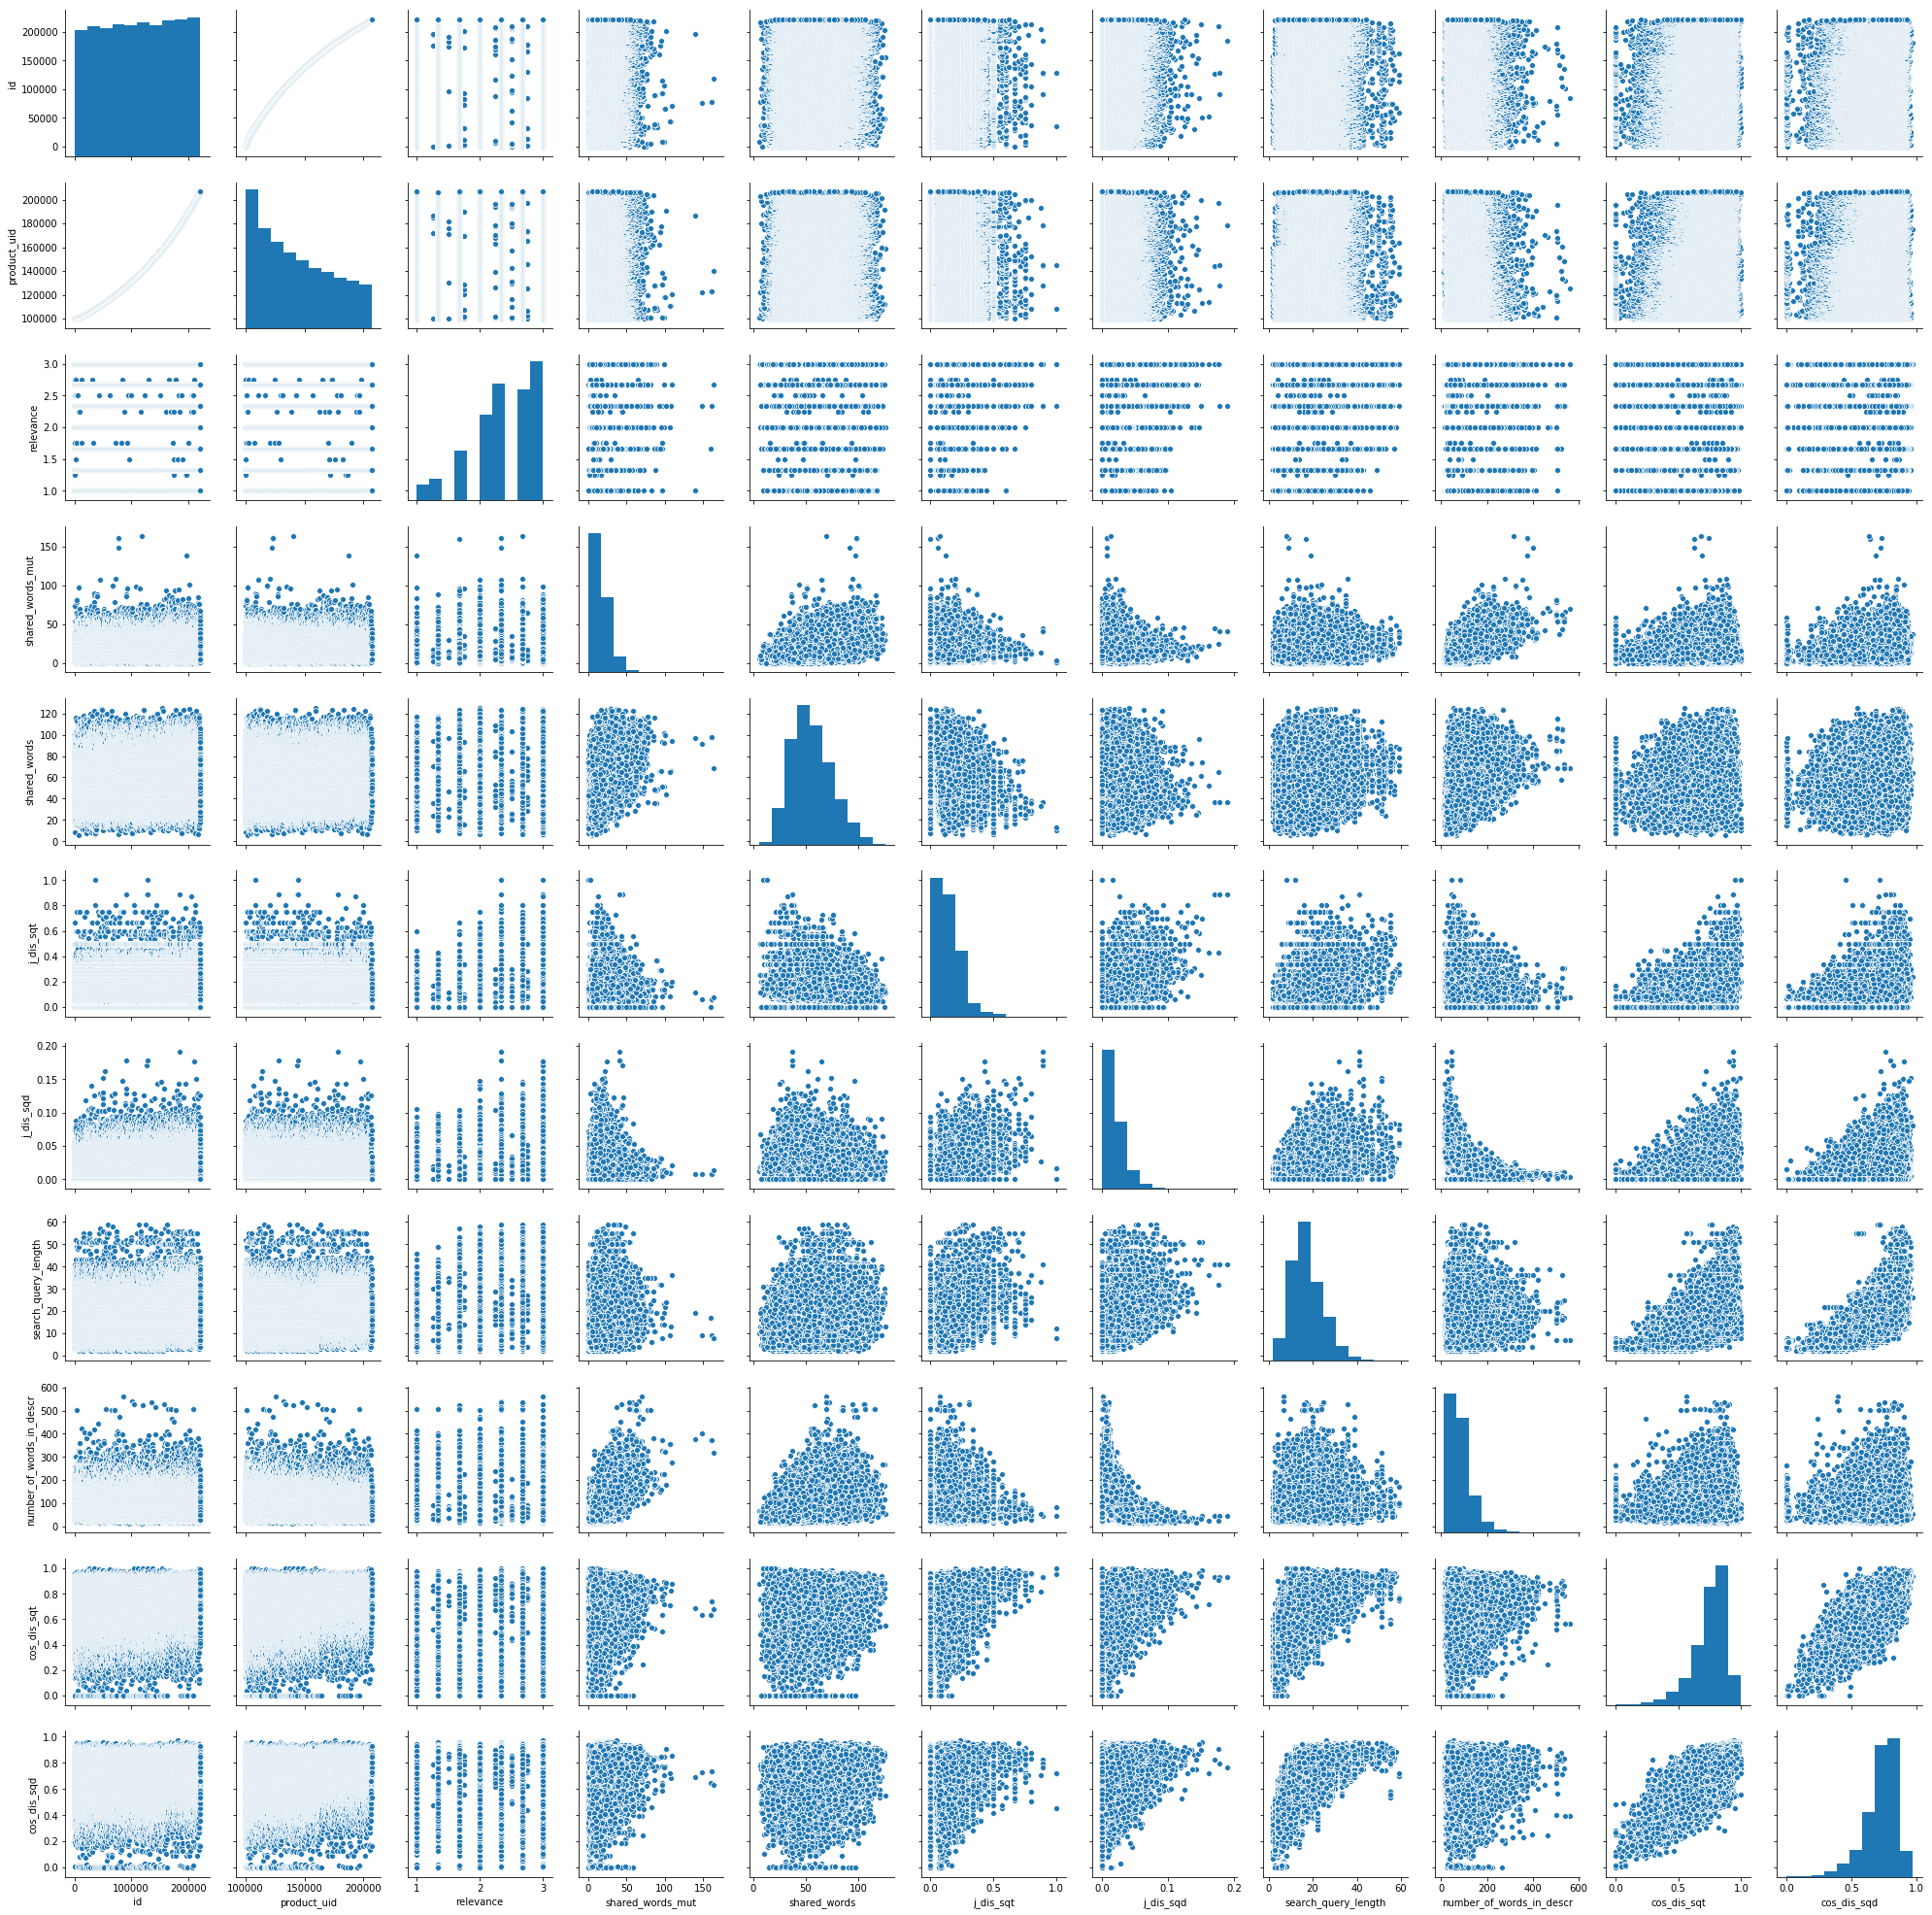

In [59]:
sns.pairplot(training_data)

In [60]:
# sns.pairplot(testing_dataing_data)

NameError: name 'testing_dataing_data' is not defined

# 3. Let's start machine learning
first of all let's create training and test data sets


We are going to apply the following models:
1. RandomForestRegressor
2. LinearRegression
4. GradientBoostingRegressor 
5. BaggingRegressor
6. Chain model withing pipeline
7. XGBoost
8. CatBoost
9. Naive Baies
10. PolynomialFeatures for all previous algorithms


### Plan
We are going to do the following:
0. Define pipeline
1. drop non numeric columns because these information has been already transformed to numberic
2. Apply the model which has been mentioned above within pipeline mode and outside pipeline
3. Train models and compare their result on __test__ dataset
4. write a summary about it





In [62]:
df_training = training_data.drop(['product_title','search_term','product_description', 'product_title_tokens', 'product_description_tokens','product_title_tokens','search_term_tokens'],axis=1)

y_train = df_training['relevance'].values
X_train = df_training.drop(['id','relevance'],axis=1).values

In [63]:
df_training.head(3)

id  product_uid     ...       cos_dis_sqt  cos_dis_sqd
0   2       100001     ...          0.584761     0.667018
1   3       100001     ...          0.437595     0.635434
2   9       100002     ...          0.783244     0.700815

[3 rows x 11 columns]

In [64]:
# X_test = testing_data.drop(['id','product_title','search_term','product_description'],axis=1).values
X_test = testing_data.drop(['id','product_title','search_term','product_description', 'product_title_tokens', 'product_description_tokens','product_title_tokens','search_term_tokens'],axis=1).values

id_test = testing_data['id']


## 3.1 RandomForestRegressor

In [65]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 1, n_jobs = -1, random_state = 17, verbose = 1)
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


id,relevance
1,3.0
4,2.33
5,2.0
6,3.0
7,2.0
8,1.67
10,3.0
11,3.0
12,1.67
13,2.67
14,2.33
15,2.33
19,3.0
22,2.0
24,3.0
25,2.0
26,2.33
28,3.0
29,1.67
30,2.67
31,2.67
32,2.67
33,1.0
36,2.67
39,2.0
40,3.0
41,3.0
42,2.0
43,1.67
44,3.0
45,2.67
46,2.0
47,2.33
49,1.67
50,1.0
52,2.67
53,2.33
54,1.67
55,2.67
56,2.67
57,1.75
58,2.0
59,2.67
60,2.33
61,2.33
62,2.0
63,3.0
64,2.0
66,2.33
67,2.0
68,1.67
70,1.67
71,3.0
72,3.0
73,1.33
74,2.33
76,3.0
77,1.0
78,2.33
79,2.67
80,1.0
82,2.0
83,3.0
84,1.67
86,2.0
87,3.0
89,2.33
91,2.33
93,1.0
94,2.33
95,2.0
96,2.0
97,2.6699999999999995
98,1.33
99,2.67
100,1.67
102,3.0
103,2.33
104,2.6699999999999995
107,2.67
108,2.33
109,2.33
110,3.0
111,3.0
112,2.33
115,1.0
116,2.67
118,2.3300000000000005
119,1.33
121,3.0
124,3.0
126,3.0
128,2.0
129,3.0
130,3.0
131,2.0
132,3.0
133,1.67
134,2.0
135,2.67
137,2.0
139,2.33
140,2.67
141,1.67
142,3.0
144,2.67
145,2.67
146,2.0
148,2.0
151,1.67
152,2.33
153,1.0
154,1.0
155,2.0
156,2.33
159,2.0
160,2.0
161,2.67
163,3.0
167,2.0
168,3.

57744,2.67
57746,3.0
57748,3.0
57749,1.0
57755,2.67
57759,3.0
57761,2.33
57763,1.67
57764,2.33
57767,3.0
57768,2.33
57769,1.67
57770,2.0
57771,2.0
57772,2.0
57774,2.0
57776,1.0
57777,3.0
57779,1.33
57780,2.67
57781,2.67
57783,1.33
57784,3.0
57785,2.0
57786,2.0
57788,2.33
57791,2.0
57793,3.0
57794,3.0
57797,2.67
57798,2.0
57799,3.0
57801,3.0
57803,2.33
57804,3.0
57805,1.0
57807,2.33
57808,2.0
57809,3.0
57810,2.0
57811,2.3300000000000005
57812,2.67
57814,2.67
57815,1.67
57816,3.0
57817,2.0
57818,3.0
57820,3.0
57821,2.33
57822,3.0
57823,2.33
57828,3.0
57830,3.0
57831,2.67
57832,3.0
57833,2.0
57834,2.67
57835,3.0
57836,2.33
57839,2.33
57840,2.67
57841,2.33
57842,2.67
57843,2.67
57844,2.0
57846,1.67
57848,2.33
57849,3.0
57850,2.0
57851,2.67
57852,3.0
57853,3.0
57854,2.0
57857,2.67
57862,2.67
57863,1.33
57865,3.0
57868,3.0
57870,2.0
57871,2.33
57873,2.0
57875,2.67
57876,3.0
57877,3.0
57878,1.0
57879,2.33
57883,1.67
57884,2.33
57885,2.0
57886,1.67
57887,2.0
57889,2.33
57892,3.0
57893,2.33
578

113437,3.0
113438,2.67
113439,2.33
113441,2.3300000000000005
113442,2.0
113443,2.33
113444,2.67
113449,2.33
113451,1.0
113452,2.33
113453,2.0
113455,3.0
113456,2.33
113457,1.0
113459,2.67
113460,2.0
113461,3.0
113462,3.0
113465,2.67
113466,3.0
113467,3.0
113468,2.67
113469,2.33
113470,2.33
113471,2.0
113472,1.33
113473,2.0
113474,1.67
113475,2.67
113476,2.33
113477,1.33
113478,2.33
113479,2.0
113480,3.0
113483,2.0
113484,2.33
113487,2.33
113488,2.33
113489,2.0
113490,2.0
113491,2.0
113492,2.67
113493,2.33
113494,3.0
113496,3.0
113498,1.67
113499,1.0
113500,2.3299999999999996
113501,2.33
113502,3.0
113503,2.67
113504,3.0
113506,2.0
113507,3.0
113508,3.0
113509,2.33
113510,2.67
113513,3.0
113514,1.67
113516,2.0
113518,2.0
113519,2.67
113522,3.0
113524,3.0
113526,2.67
113527,2.67
113528,2.0
113530,2.33
113531,3.0
113533,3.0
113534,3.0
113536,3.0
113537,3.0
113540,3.0
113544,3.0
113545,3.0
113547,3.0
113548,3.0
113549,3.0
113550,2.33
113551,2.33
113552,1.67
113553,3.0
113554,1.33
113556,2.

162359,2.67
162360,2.67
162361,1.33
162364,2.33
162365,3.0
162366,3.0
162367,3.0
162368,3.0
162369,2.67
162371,2.67
162373,2.33
162375,1.33
162376,2.33
162377,2.0
162379,2.67
162380,2.33
162381,2.67
162382,2.67
162384,2.67
162385,3.0
162386,2.0
162387,2.33
162388,3.0
162389,1.33
162390,1.67
162391,2.33
162392,2.67
162393,2.67
162395,3.0
162397,2.67
162398,2.33
162400,1.67
162402,2.67
162405,1.33
162407,3.0
162408,3.0
162409,2.67
162410,1.67
162411,2.67
162412,2.67
162413,2.67
162415,2.33
162416,3.0
162419,3.0
162420,2.0
162421,2.67
162422,1.67
162423,1.33
162424,3.0
162426,2.33
162427,2.0
162428,1.67
162429,3.0
162430,3.0
162432,2.0
162435,2.33
162436,3.0
162437,3.0
162439,1.67
162440,3.0
162441,1.0
162442,3.0
162443,3.0
162444,2.33
162445,2.33
162446,1.67
162447,2.67
162448,3.0
162450,3.0
162451,1.67
162452,1.67
162453,3.0
162455,3.0
162456,2.33
162457,1.67
162458,2.33
162460,2.67
162461,2.33
162463,3.0
162465,2.67
162466,2.0
162468,2.67
162471,1.0
162473,2.0
162474,3.0
162475,2.33
16

214228,3.0
214229,2.67
214230,1.67
214231,1.33
214232,2.0
214234,2.33
214235,1.33
214236,2.67
214237,1.0
214238,1.0
214240,3.0
214242,2.33
214244,2.0
214245,2.33
214246,2.33
214247,1.0
214248,3.0
214250,1.67
214251,2.67
214252,1.67
214257,2.0
214262,2.33
214263,2.0
214264,2.33
214266,3.0
214268,1.67
214269,2.67
214271,2.33
214272,2.67
214275,1.67
214276,3.0
214278,3.0
214279,2.67
214281,2.33
214283,1.33
214284,1.67
214285,2.0
214287,3.0
214288,2.6699999999999995
214289,2.67
214290,2.0
214294,2.67
214295,2.33
214298,2.0
214299,3.0
214300,2.0
214301,2.33
214302,3.0
214303,2.33
214305,2.33
214306,1.67
214307,1.0
214308,2.33
214309,2.67
214311,1.0
214312,2.0
214313,2.6700000000000004
214314,2.0
214315,1.0
214316,2.67
214317,1.67
214319,3.0
214321,2.33
214324,3.0
214325,3.0
214326,2.0
214327,2.33
214328,1.0
214330,1.0
214331,2.33
214334,3.0
214335,2.0
214336,3.0
214338,2.0
214339,2.33
214340,2.0
214341,1.67
214342,1.67
214345,2.33
214346,2.33
214348,1.0
214349,3.0
214353,1.0
214355,2.33
214

## 3.2 LinearRegression


In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(n_jobs = -1)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)

## 3.3 GradientBoostingRegressor

In [ ]:
import sklearn
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
                'loss' : ['ls'],
                'n_estimators' : [3], 
                'max_depth' : [9],
                'max_features' : ['auto'] 
             }

gbr = GradientBoostingRegressor()

model_gbr = sklearn.model_selection.GridSearchCV(estimator = gbr, n_jobs = -1, param_grid = param_grid)
model_gbr.fit(X_train, y_train)

y_pred = model_gbr.predict(X_test)

# pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)

## 3.4 BaggingRegressor based on  RandomForestRegressor

In [ ]:
from sklearn.ensemble import BaggingRegressor
rf = RandomForestRegressor(max_depth = 20, max_features =  'sqrt', n_estimators = 3)
clf = BaggingRegressor(rf, n_estimators=3, max_samples=0.1, random_state=25)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)

In [ ]:
cat

## 3.5 Chain model withing pipeline


In [ ]:
# define models which will be chained togher in a bigger model, which aims to predict the relevancy score
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

#define standard scaler
scaler = StandardScaler()
scaler.fit(X_train, y_train)
scaled_train_data = scaler.transform(X_train)
scaled_test_data = scaler.transform(X_test)


rf = RandomForestRegressor(n_estimators=4, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=4, max_samples=0.1, random_state=25)


pipeline = Pipeline(steps = [('scaling', scaler), ('baggingregressor', clf)])
#end pipeline 
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)


## 3.6 Naive Bayes

In [ ]:
from sklearn.linear_model import BayesianRidge

gnb = BayesianRidge()
param_grid = {}
model_nb = sklearn.model_selection.GridSearchCV(estimator = gnb, param_grid = param_grid, n_jobs = -1)
model_nb.fit(X_train, y_train)

y_pred = model_nb.predict(X_test)
# pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)

## 3.7 XGBoost

In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
param_grid = {'max_depth':[5, 6], 
              'n_estimators': [130, 150, 170], 
              'learning_rate' : [0.1]}
model_xgb = sklearn.model_selection.GridSearchCV(estimator = xgb, param_grid = param_grid, n_jobs = -1)
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)
# pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)


# Results



|Regressor|Train|Kaggle
|:----------------------|----------|----------|
|CatBoostRegressor|-|-|
|XGBRegressor|-|-|
|GradientBoostingRegressor|-|-|
|PolynomialFeatures on GradientBoostingRegressor|-|-|
|PolynomialFeatures on XGBRegressor|-|-|
|PolynomialFeatures on LinearRegression|-|-|
|PolynomialFeatures on BaggingRegressor on RandomForestRegressor|-|-|
|BaggingRegressor on RandomForestRegressor|0.53480|0.53427|
|Chaining toghether using Pipeline|0.53063|0.53100|
|BayesianRidge|-|-|
|LinearRegression|-|-|
|PolynomialFeatures on BayesianRidge|-|-|
|RandomForestRegressor|0.59063|0.58869|
